In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 30)
#pd.set_option('display.width', 800)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from pylab import rcParams
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2

In [2]:
data = pd.read_csv('input/train.csv')

In [3]:
#GET DUMMIES +3 columns
data = pd.get_dummies(data)

### Prepare data

In [4]:
def clear_rooms(df):
    df.loc[df['Rooms'] < 1, 'Rooms'] = 1
    df.loc[df['Rooms'] > 5, 'Rooms'] = 5
    return df

In [5]:
def clear_house_year(df):
    df.loc[df['HouseYear'] < 1900, 'HouseYear'] = 1900
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    return df

In [6]:
def clear_floor(df):
    df.loc[(df['HouseFloor'] < 1) ,'HouseFloor'] = 1
    df.loc[(df['Floor'] < 1) ,'Floor'] = 1
    return df

In [7]:
def prepare_floor(df, source_df):
    df.loc[(df['Floor'] > df['HouseFloor']) ,'Floor'] = df['HouseFloor']
    mean_Floor = source_df.groupby(['HouseFloor','HouseYear'], as_index=False)[['Floor']].median().rename(columns={'Floor':'mean_Floor'})
    df = pd.merge(df, mean_Floor, on=['HouseFloor','HouseYear'], how = 'left')
    df['Floor'] = df['Floor'].fillna(df['mean_Floor'])
    return df

In [8]:
def prepare_house_floor(df, source_df):
    mean_HouseFloor = source_df.groupby(['HouseYear'], as_index=False)[['HouseFloor']].median().rename(columns={'HouseFloor':'mean_HouseFloor'})
    df = pd.merge(df, mean_HouseFloor, on=['HouseYear'], how = 'left')
    df.loc[(df['HouseFloor'] > 37) ,'HouseFloor'] = df['mean_HouseFloor']
    return df

In [9]:
def clear_square(df, col):
#     df.loc[df[col] < 15, col] = 15
    df.loc[df[col] > 300, col] = 300
    df.loc[df[col] > df['Square'] , col] = df['Square']
    return df

In [10]:
def prepare_square(df, source_df, col):
    mean_col = '{0}{1}'.format('mean_', col)
    mean_Square = source_df.groupby(['Rooms', 'HouseFloor', 'HouseYear'], 
                                    as_index=False)[[col]].median().rename(columns={col:mean_col})
    df = pd.merge(df, mean_Square, on=['Rooms', 'HouseFloor', 'HouseYear'], how = 'left')
    df[col] = df[col].fillna(df[mean_col])
    return df

In [11]:
def fillna_square(df, source_df, col):
    df[col] = df[col].fillna(source_df[col].median())
    return df

In [12]:
def fillna_healthcare_1(df, source_df):
    mean_Healthcare_1 = source_df.groupby(['DistrictId'], as_index=False)[['Healthcare_1']].mean().rename(columns={'Healthcare_1':'mean_Healthcare_1'})
    mean_Healthcare_1['mean_Healthcare_1'] = mean_Healthcare_1['mean_Healthcare_1'].fillna(mean_Healthcare_1['mean_Healthcare_1'].mean())
    df = pd.merge(df, mean_Healthcare_1, on=['DistrictId'], how = 'left')
    df['Healthcare_1'] = df['Healthcare_1'].fillna(df['mean_Healthcare_1'])
    df['Healthcare_1'] = df['Healthcare_1'].fillna(df['Healthcare_1'].mean())
    #df.to_csv('output/df_Healthcare_1.csv')
    return df


In [13]:
def prepare_df(df, source_df):
    df = clear_rooms(df)
    df = clear_house_year(df)
    df = clear_floor(df)
    df = prepare_floor(df, source_df)
    df = prepare_house_floor(df, source_df)
    df = clear_square(df, 'Square')
    df = clear_square(df, 'LifeSquare')
    df = clear_square(df, 'KitchenSquare')
    df = prepare_square(df, source_df, 'Square')
    df = prepare_square(df, source_df, 'LifeSquare')
    df = fillna_square(df, source_df, 'Square')
    df = fillna_square(df, source_df, 'LifeSquare')
#     df = fillna_healthcare_1(df, source_df) 
#     df['Square_2'] = df['Square']**2
    return df

In [14]:
feats = ['Rooms','Square','HouseFloor', 'Floor', 'DistrictId','Ecology_1','Social_1','Social_2','Social_3',
          'Helthcare_2', 'Ecology_2_A', 'Ecology_2_B', 'KitchenSquare']

In [15]:
### bruteforce: test_size, n_estimators, max_depth, random_state

In [ ]:
test_size = 0.2 #test_size = 0.3
n_estimators_arr = np.arange(10, 320, 5)
max_depth_arr = np.arange(14, 19, 1)
random_state_arr = np.arange(8, 9, 1)
r2_train_arr = []
r2_valid_arr = []
for random_state in random_state_arr:
    train, valid = train_test_split(data, test_size=test_size, random_state=random_state)
    train = prepare_df(train, train)
    valid = prepare_df(valid, train) 
    for max_depth in max_depth_arr:
        for n_estimators in n_estimators_arr:
            model = RF(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
            model.fit(train.loc[:, feats], train['Price'])
            pred_train = model.predict(train.loc[:, feats])
            pred_valid = model.predict(valid.loc[:, feats])
            r2_train = r2(train['Price'], pred_train)
            r2_valid = r2(valid['Price'], pred_valid)
            r2_train_arr.append(r2_train)
            r2_valid_arr.append(r2_valid)
#             print('{} {} {}: {} {}'.format(random_state, n_estimators, max_depth, r2_train, r2_valid))

In [ ]:
### Best results:
# 8 300 14: 0.9224005531103456 0.7536682129462674 test_size=0.3
# 8 305 16: 0.9422691317641188 0.7576092695449609 test_size=0.2
# 8 56 16: 0.9413199802650309 0.7572575841405197 test_size=0.2
# 8 56 14: 0.9209109084894638 0.7591132924522228 test_size=0.2

In [41]:
test_size = 0.2
n_estimators = 56
max_depth_arr = np.arange(10, 18, 1)
random_state = 8
r2_train_arr = []
r2_valid_arr = []
for max_depth in max_depth_arr:
    train, valid = train_test_split(data, test_size=test_size, random_state=random_state)
    train = prepare_df(train, train)
    valid = prepare_df(valid, train) 
    model = RF(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(train.loc[:, feats], train['Price'])
    pred_train = model.predict(train.loc[:, feats])
    pred_valid = model.predict(valid.loc[:, feats])
    r2_train = r2(train['Price'], pred_train)
    r2_valid = r2(valid['Price'], pred_valid)
    r2_train_arr.append(r2_train)
    r2_valid_arr.append(r2_valid)

Text(0.5,1,'test_size=0.2, random_state=8,  n_estimators=56: r2(max_depth)')

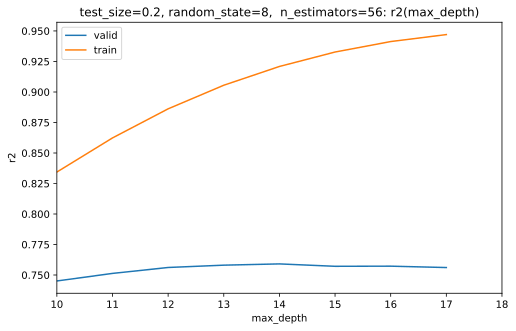

In [42]:
rcParams['figure.figsize'] = 8, 5
plt.plot(max_depth_arr, r2_valid_arr)
plt.plot(max_depth_arr, r2_train_arr)
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.legend(['valid', 'train'])
plt.xlim(10, 18)
plt.title('test_size={}, random_state={},  n_estimators={}: r2(max_depth)'.format(test_size, random_state, n_estimators))

In [45]:
test_size = 0.2
n_estimators_arr = np.arange(30, 60, 2)
max_depth = 14
random_state_arr = 8
r2_train_arr = []
r2_valid_arr = []
for n_estimators in n_estimators_arr:
    train, valid = train_test_split(data, test_size=test_size, random_state=random_state)
    train = prepare_df(train, train)
    valid = prepare_df(valid, train) 
    model = RF(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(train.loc[:, feats], train['Price'])
    pred_train = model.predict(train.loc[:, feats])
    pred_valid = model.predict(valid.loc[:, feats])
    r2_train = r2(train['Price'], pred_train)
    r2_valid = r2(valid['Price'], pred_valid)
    r2_train_arr.append(r2_train)
    r2_valid_arr.append(r2_valid)

Text(0.5,1,'test_size=0.2, random_state=8,  max_depth=14: r2(n_estimators)')

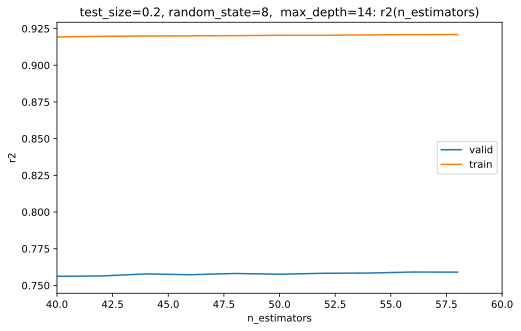

In [46]:
rcParams['figure.figsize'] = 8, 5
plt.plot(n_estimators_arr, r2_valid_arr)
plt.plot(n_estimators_arr, r2_train_arr)
plt.xlabel('n_estimators')
plt.ylabel('r2')
plt.legend(['valid', 'train'])
plt.xlim(40, 60)
plt.title('test_size={}, random_state={},  max_depth={}: r2(n_estimators)'.format(test_size, random_state, max_depth))

In [48]:
### Test
test = pd.read_csv('input/test.csv')
test.shape
test = pd.get_dummies(test)
test = prepare_df(df=test, source_df=train)

In [49]:
model = RF(n_estimators=56, max_depth=14, random_state=8)
model.fit(train.loc[:, feats], train['Price'])
test['Price'] = model.predict(test.loc[:, feats])
test.loc[:, ['Id', 'Price']].to_csv('output/RRZagidullin_predictions.csv', index=None)